# TinyML Speech Recognition Model
This project focuses on developing a speech recognition system that classifies audio commands using TensorFlow. The system recognizes spoken words and categorizes them into predefined classes ("yes" and "no"). The project utilizes a dataset of audio recordings, transforms these recordings into log Mel spectrograms for model training, and evaluates the model's performance.

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import keras as ks

from keras import layers
from keras import models

from keras import models
from IPython import display

import random

# Set the seed value for experiment reproducibility 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Speech Command Dataset Analysis
Load, preprocess, and visualize the Speech Commands dataset. We use TensorFlow to manage audio data and perform basic analysis.

set up the path to the Speech Commands dataset and creates a Path object for further operations.

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

# Create a Path object from the dataset path
data_dir = pathlib.Path(DATASET_PATH)

Here, we list the directories in the dataset path to identify the available commands. We exclude `README.md` from the list.

In [3]:
# List all directories and files in data_dir
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md')]

print('Commands: ', commands)

Commands:  ['no' 'noise' 'yes']


loads the audio data from the dataset directory using TensorFlow's audio_dataset_from_directory function. It splits the data into training and validation sets with a 60-40 split.

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.4,
    seed=0,
    output_sequence_length=16000,
    subset='both')

Found 3555 files belonging to 3 classes.
Using 2133 files for training.
Using 1422 files for validation.


In [5]:
# print out the names of the labels (commands) found in the dataset.
label_names = np.array(train_ds.class_names)
print()
print("label names: ", label_names) 


label names:  ['no' 'noise' 'yes']


displays the structure of the dataset elements, showing the shape and type of the audio and label tensors.

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

preprocess the dataset by removing the extra channel dimension from the audio data using the tf.squeeze function.

In [7]:
# The dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis
def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

splits the validation dataset into two shards: one for validation and one for testing.

In [8]:
# Splitting the data to validation and testing sets.
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

take a single batch from the training dataset and print the shapes of the audio and label tensors.

In [9]:
for example_audio, example_label in train_ds.take(1):
    print(example_audio.shape)
    print(example_label.shape)

(64, 16000)
(64,)


In [10]:
# Let's plot a few audio waveforms
label_names[[0, 1]]

array(['no', 'noise'], dtype='<U5')

visualizes the audio waveforms of a few samples from the dataset. Each subplot displays the waveform of an audio sample, labeled with its corresponding command.

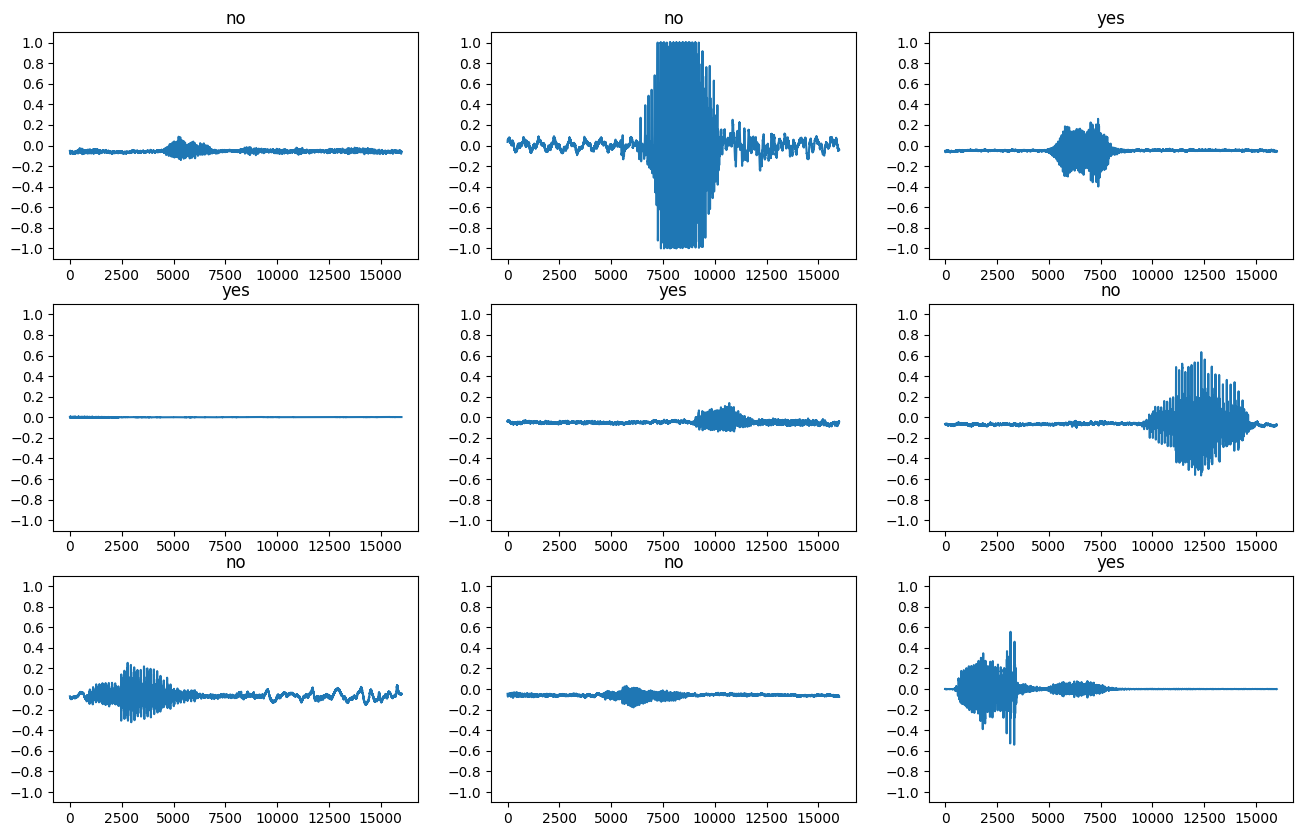

In [11]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_label[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

# Spectrogram Analysis and Processing
This section of the notebook covers the process of converting audio waveforms to spectrograms and visualizing them. We also prepare the data for training by converting audio data into log Mel spectrograms.
## Define Spectrogram Functions
defines functions for converting audio waveforms to spectrograms and log Mel spectrograms. It includes normalization to standardize the spectrogram values.

In [12]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via STFT
    spectrogram = tf.signal.stft(
        waveform, frame_length=512, frame_step=128, fft_length=512)
    # Compute the power of the STFT (magnitude squared)
    spectrogram_power = tf.abs(spectrogram) ** 2
    return spectrogram_power

def normalize_log_mel_spectrogram(log_mel_spectrogram):
    # Normalizing from range [-16, -3] to [-70, -10]
    min_input = -11.0
    max_input = -3.0
    min_output = -60.0
    max_output = -20.0

    # Performing normalization
    normalized = ((log_mel_spectrogram - min_input) / (max_input - min_input)) * (max_output - min_output) + min_output
    return normalized

def get_log_mel_spectrogram(waveform, sample_rate=16000, num_mels=40):
    # Get the spectrogram using the provided function
    spectrogram_power = get_spectrogram(waveform)
    
    # Create the Mel filter banks using the built-in function
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mels,  
        num_spectrogram_bins=spectrogram_power.shape[-1], 
        sample_rate=sample_rate,
        lower_edge_hertz=300, 
        upper_edge_hertz=sample_rate / 2 
    )
    
    # Apply the Mel filter banks to the spectrogram
    mel_spectrogram = tf.tensordot(spectrogram_power,
                                   linear_to_mel_weight_matrix,
                                   axes=[-1, 0])

    # Convert to log scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    # Normalize the log mel spectrogram
    normalized_log_mel_spectrogram = normalize_log_mel_spectrogram(log_mel_spectrogram)
    
    # Add a `channels` dimension for compatibility with convolution layers
    normalized_log_mel_spectrogram = normalized_log_mel_spectrogram[..., tf.newaxis]
    
    return normalized_log_mel_spectrogram

prints information about the shape of the waveform and its corresponding log Mel spectrogram for a few samples. It also provides audio playback for inspection.

In [13]:
for i in range(5):
    label = label_names[example_label[i]]
    waveform = example_audio[i]
    log_mel_spectrogram = get_log_mel_spectrogram(waveform)
    
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', log_mel_spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (122, 40, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (122, 40, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (122, 40, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (122, 40, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (122, 40, 1)
Audio playback


Here, we define a function to plot the log Mel spectrogram using matplotlib. The function handles spectrogram dimensions and visualizes it with appropriate settings.

In [14]:
def plot_log_mel_spectrogram(log_mel_spectrogram, ax):
    if len(log_mel_spectrogram.shape) == 3:
        # If the input tensor has a channel dimension, squeeze it
        log_mel_spectrogram = np.squeeze(log_mel_spectrogram, axis=-1)
    
    # Transpose the log Mel spectrogram for plotting
    log_mel_spec = log_mel_spectrogram.T
    height = log_mel_spec.shape[0]
    width = log_mel_spec.shape[1]
    X = np.linspace(0, width, num=width, dtype=int)
    Y = np.arange(height)
    ax.pcolormesh(X, Y, log_mel_spec, shading='gouraud')
    ax.set_ylim(0, height)  # Set y limits to the height of the spectrogram

This cell creates a subplot with two figures: one for the waveform and one for the log Mel spectrogram. It visualizes the audio signal and its spectrogram in a single view.

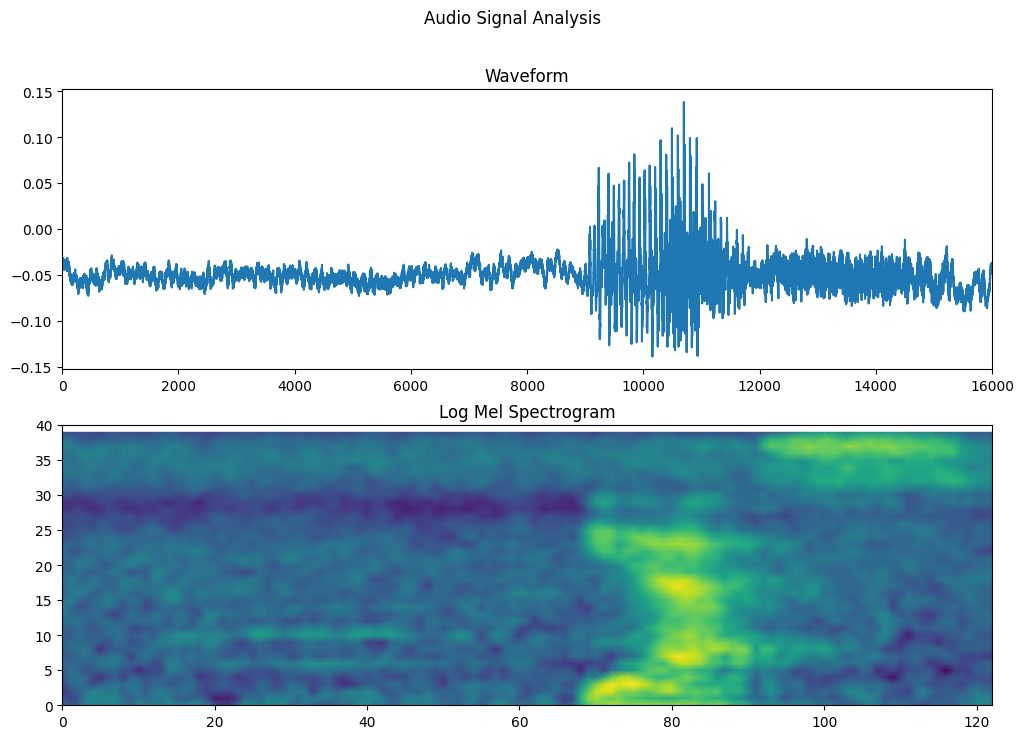

In [15]:
# Assuming waveform and log_mel_spectrogram have been defined
fig, axes = plt.subplots(2, figsize=(12, 8))

# Plot the waveform
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

# Plot the log Mel spectrogram
plot_log_mel_spectrogram(log_mel_spectrogram, axes[1])
axes[1].set_title('Log Mel Spectrogram')

# Set the overall title
plt.suptitle('Audio Signal Analysis')
plt.show()

The ``make_spec_ds`` function converts audio datasets into spectrogram datasets by applying the ``get_log_mel_spectrogram`` function to each sample.

In [16]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_log_mel_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

This cell applies the make_spec_ds function to the training, validation, and testing datasets to convert them into spectrogram datasets.

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [18]:
for example_spectrogram, example_spect_labels in train_spectrogram_ds.take(1):
    break

In this cell, we visualize a grid of log Mel spectrograms from the training dataset. Each subplot displays a spectrogram with its corresponding label.

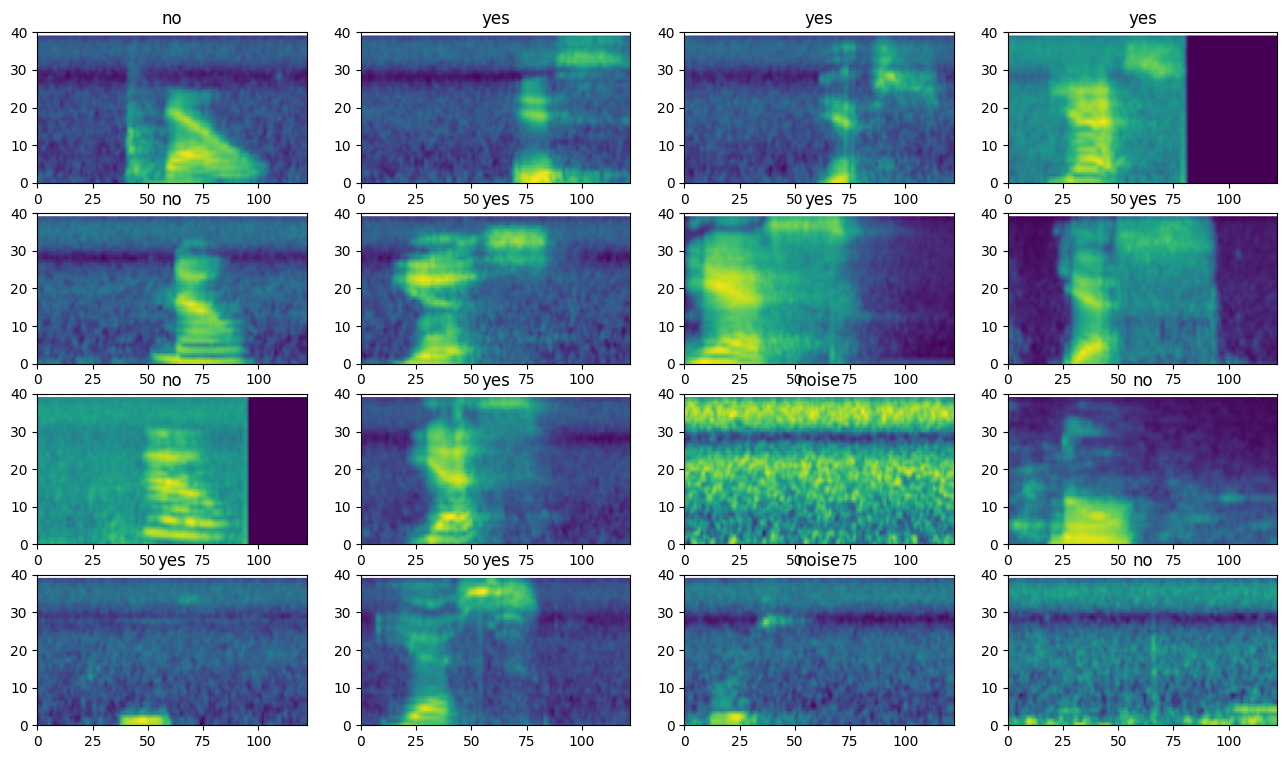

In [19]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_log_mel_spectrogram(example_spectrogram[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

# Model Training and Evaluation
This section of the notebook covers the preparation of datasets for training, the creation of a neural network model, and the evaluation of its performance.
## Prepare Spectrogram Datasets for Training
Here, we optimize the datasets for performance by caching, shuffling, and prefetching. This ensures efficient loading and processing during model training and evaluation.

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Define and Build the Model
Now that we have the features extracted from the audio signal, we can create a model using TensorFlow’s Keras API. The model will consist of 9 layers:

- An input layer.
- A preprocessing layer, that will resize the input tensor from 122x40x1 to 32x32x1.
- A normalization layer, that will scale the input values between -1 and 1
- A 2D convolution layer with: 8 filters, a kernel size of 8x8, and stride of 2, and ReLU activation function.
- A 2D max pooling layer with size of 2x2
- A flatten layer to flatten the 2D data to 1D
- A dropout layer, that will help reduce over-fitting during training
- A dense layer with 32 neurons 
- A dense layer with 3 neurons with a SoftMax Activation function, which outputs 3 classes [no, noise, yes]

![TinyML Embedded Model](../images/Embedded%20Speech%20Model%20Architecture.png)


In [21]:
input_shape = example_spectrogram.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(filters=8, kernel_size=(8, 8), strides=(2, 2), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='softmax'),
])


# Print model summary
model.summary()

Input shape: (122, 40, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 13, 13, 8)      │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,870 (38.56 KB)

 Trainable params: 9,867 (38.54 KB)

 Non-trainable params: 3 (16.00 B)

Here, we compile the model with the Adam optimizer and SparseCategoricalCrossentropy loss function, specifying accuracy as the evaluation metric.

In [22]:
model.compile(
    optimizer=ks.optimizers.Adam(),
    loss=ks.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

This cell trains the model using the training and validation datasets for a specified number of epochs. Optionally, early stopping can be enabled to prevent overfitting.

In [23]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100


c:\Users\karim\anaconda3\envs\actia_speech\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4287 - loss: 1.0788 - val_accuracy: 0.6903 - val_loss: 0.7247
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6954 - loss: 0.7146 - val_accuracy: 0.7770 - val_loss: 0.5660
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7520 - loss: 0.5827 - val_accuracy: 0.7855 - val_loss: 0.5135
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7815 - loss: 0.5330 - val_accuracy: 0.7997 - val_loss: 0.4743
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7838 - loss: 0.4834 - val_accuracy: 0.8196 - val_loss: 0.4326
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8128 - loss: 0.4476 - val_accuracy: 0.8295 - val_loss: 0.3933
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8123 - loss: 0.4408 - val_accuracy: 0.8239 - val_loss: 0.3763
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8244 - loss: 0.4220 - val_accuracy: 0.8480 - val_loss: 0.

We plot the training and validation loss and accuracy over epochs to visualize the model's performance and learning progress.

Text(0, 0.5, 'Accuracy [%]')

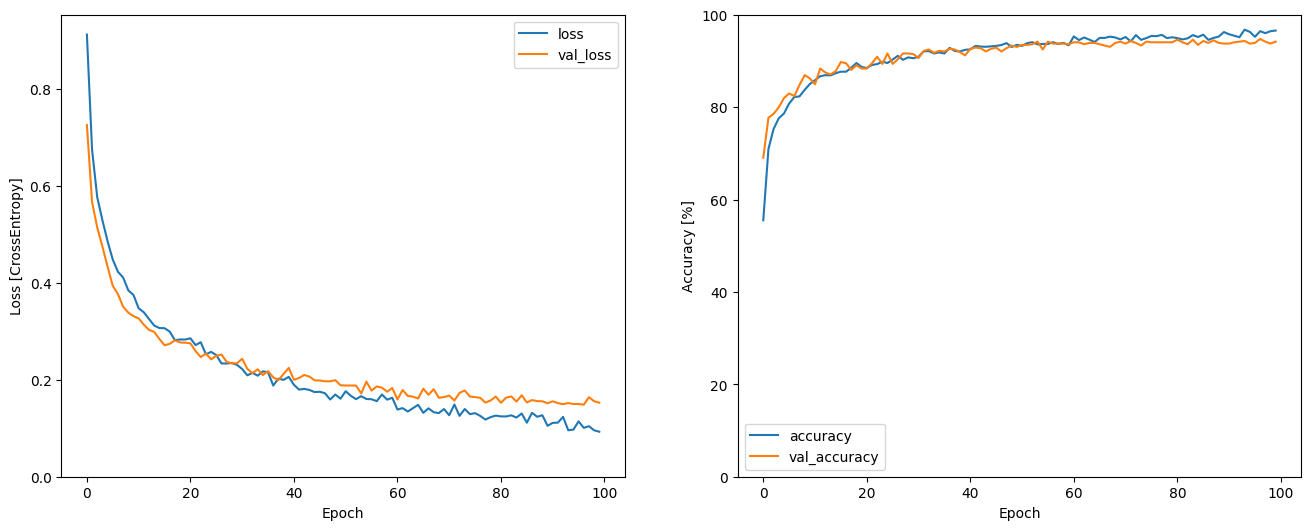

In [24]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate Model Performance
This cell evaluates the model on the test dataset, makes predictions, and prepares true labels for comparison.

In [25]:
model.evaluate(test_spectrogram_ds, return_dict=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9638 - loss: 0.1206


{'accuracy': 0.9637883305549622, 'loss': 0.1099867895245552}

In [26]:
y_pred = model.predict(test_spectrogram_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [27]:
print(y_pred.shape)

(718, 3)


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

We plot a confusion matrix to visualize the performance of the model in classifying the different commands, comparing predictions with true labels.

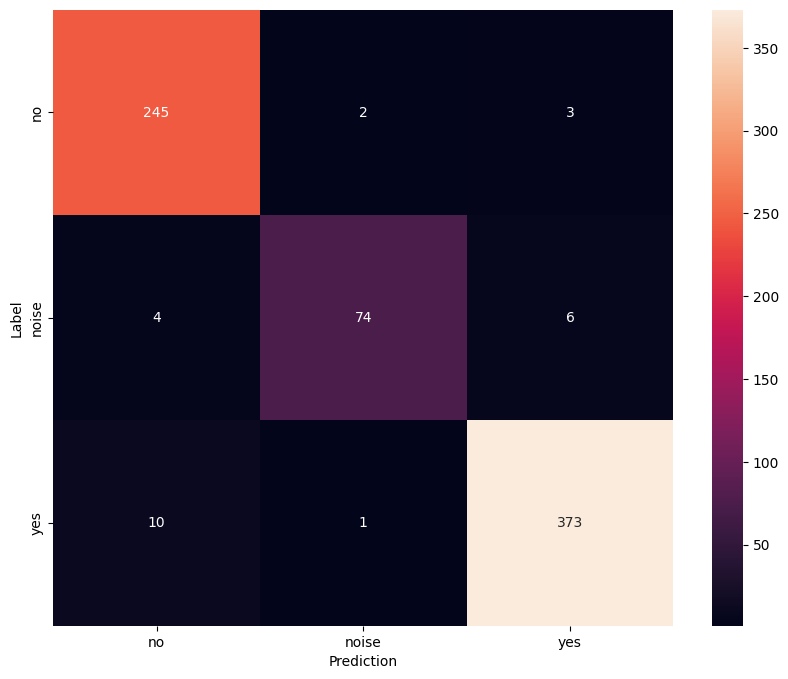

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Finally, we test the trained model with a sample audio file, showing the prediction probabilities for each class and playing the audio for verification.

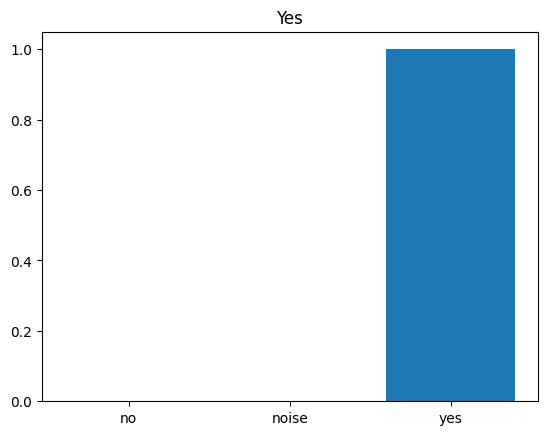

In [31]:
x = data_dir/'yes/audio_6.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_log_mel_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'noise' ,'yes']
plt.bar(x_labels, prediction[0])
plt.title('Yes')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Model Embedded Conversion and Saving
This section covers the conversion of the trained model to TensorFlow Lite format and saving it for deployment.
## Define File Paths for Models
In this cell, we define the file paths where the TensorFlow Keras model and its TensorFlow Lite versions will be saved.

In [32]:
# Make a Directory
MODELs_DIR_PATH = 'models/'

MODEL_TF = MODELs_DIR_PATH + 'model.keras'  # Added .keras extension
MODEL_NO_QUANT_TFLITE = MODELs_DIR_PATH + 'model_no_quant.tflite'
MODEL_TFLITE = MODELs_DIR_PATH + 'model.tflite'

In [ ]:
# Save the model to an HDF5 file
model.save('model.h5')

## Convert the Model to TensorFlow Lite Format Without Quantization
This cell performs the conversion of the trained Keras model to TensorFlow Lite format without quantization. It also saves the converted model to disk and handles potential conversion errors.

In [33]:
# Convert the model to TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set compatibility options
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite built-in ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops
]

try:
    model_no_quant_tflite = converter.convert()
    # Save the model to disk
    with open(MODEL_NO_QUANT_TFLITE, "wb") as f:
        f.write(model_no_quant_tflite)
    print("Model converted and saved successfully.")
except Exception as e:
    print("Error during conversion:", e)

INFO:tensorflow:Assets written to: C:\Users\karim\AppData\Local\Temp\tmpeon5xztp\assets


INFO:tensorflow:Assets written to: C:\Users\karim\AppData\Local\Temp\tmpeon5xztp\assets


Saved artifact at 'C:\Users\karim\AppData\Local\Temp\tmpeon5xztp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 122, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2250381497680: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  2250381493648: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  2250381505744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250381493072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250381499984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250381492688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250381497488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2250381493456: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model converted and saved successfully.
